# Inicialização

In [14]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snscrape.modules.twitter as sntwitter
from tqdm import tqdm

# Oculta warnings do notebook
# import warnings
# warnings.filterwarnings('ignore')

# Configurações de visualização
pd.set_option('display.max_columns', 30)
pd.options.display.float_format = '{:,.2f}'.format

In [15]:
# Carregando dataset com os dados dos candidatos de SP nas eleições de 2022
dataset_path = 'datasets/'
cand_sp_df = pd.read_csv(f"{dataset_path}consulta_cand_2022_SP.csv", sep=';')
print(cand_sp_df.shape)
cand_sp_df.info()

(3659, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DT_GERACAO                     3659 non-null   object 
 1   HH_GERACAO                     3659 non-null   object 
 2   ANO_ELEICAO                    3659 non-null   int64  
 3   CD_TIPO_ELEICAO                3659 non-null   int64  
 4   NM_TIPO_ELEICAO                3659 non-null   object 
 5   NR_TURNO                       3659 non-null   int64  
 6   CD_ELEICAO                     3659 non-null   int64  
 7   DS_ELEICAO                     3659 non-null   object 
 8   DT_ELEICAO                     3659 non-null   object 
 9   TP_ABRANGENCIA                 3659 non-null   object 
 10  SG_UF                          3659 non-null   object 
 11  SG_UE                          3659 non-null   object 
 12  NM_UE                          3659 n

In [16]:
# Carregando dataset com os dados de redes sociais dos candidatos de SP nas eleições de 2022
rs_df = pd.read_csv(f"{dataset_path}rede_social_candidato_2022_SP.csv", sep=';')
print(rs_df.shape)
rs_df.info()

(6735, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6735 entries, 0 to 6734
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   DT_GERACAO       6735 non-null   object
 1   HH_GERACAO       6735 non-null   object
 2   AA_ELEICAO       6735 non-null   int64 
 3   SG_UF            6735 non-null   object
 4   CD_TIPO_ELEICAO  6735 non-null   int64 
 5   NM_TIPO_ELEICAO  6735 non-null   object
 6   CD_ELEICAO       6735 non-null   int64 
 7   DS_ELEICAO       6735 non-null   object
 8   SQ_CANDIDATO     6735 non-null   int64 
 9   NR_ORDEM         6735 non-null   int64 
 10  DS_URL           6735 non-null   object
dtypes: int64(5), object(6)
memory usage: 578.9+ KB


## Juntando os datasets

In [17]:
# Filtrando somente candidatos com conta no Twitter
rs_twitter_df = rs_df[rs_df.DS_URL.str.contains('twitter', case=False)]
print(rs_twitter_df.shape)

(624, 11)


In [18]:
# Juntando as duas bases
df = pd.merge(cand_sp_df, rs_twitter_df[['SQ_CANDIDATO', 'DS_URL']], on="SQ_CANDIDATO", how="left")
df.shape

(3682, 72)

In [19]:
# Filtrando somente candidatos a deputado estadual
candidates_df = df.loc[
    (df['DS_CARGO'] == 'DEPUTADO ESTADUAL')
]

print(candidates_df.shape)

(2068, 72)


# Checagem dos dados

## Dados duplicados

In [20]:
# Vamos checar os candidatos duplicados
duplicated_candidates_id = (candidates_df.SQ_CANDIDATO.value_counts() > 1).loc[lambda x: x == True].index
candidates_df[candidates_df['SQ_CANDIDATO'].isin(duplicated_candidates_id)][['SQ_CANDIDATO', 'DS_URL']]

,SQ_CANDIDATO,DS_URL
179,250001643640,https://twitter.com/DrMarcioAurelio
180,250001643640,https://twitter.com/DrMarcioAurelio
181,250001643640,https://twitter.com/raiztrabalhista
578,250001619366,https://twitter.com/MarinadaMantiq1?t=8vFxK3Hx...
579,250001619366,https://twitter.com/Mantiqueira18?t=hLpMVYYVZ0...
885,250001611799,https://twitter.com/depeniotatto
886,250001611799,https://www.twitter.com/eniotatto13114
2344,250001620657,https://www.twitter.com/FabioAdonis
2345,250001620657,https://twitter.com/fabiojabaDGtal?t=45hkTz2X4...
2688,250001611457,https://twitter.com/alefrota77


In [21]:
# Vamos checar estas contas no Twitter
drop_list = []

# A conta DrMarcioAurelio está repetida, portanto vamos remover uma das linhas
drop_list.append(180)

# A conta raiztrabalhista é de um coletivo político e não do candidato
drop_list.append(181)

# A conta Mantiqueira18 é de um coletivo político e não do candidato
drop_list.append(579)

# A conta eniotatto13114 não existe mais
drop_list.append(886)

# A conta FabioAdonis é pessoal e não posta desde 2017
drop_list.append(2344)

# A conta alefrota77 não existe mais
drop_list.append(2688)

# A conta GeraldóNobrega não existe mais
drop_list.append(2784)

# A conta rodrigo_pt13 não tem nenhum tweet
drop_list.append(3442)

# A conta valverdemogi possui apenas um tweet de 2021
drop_list.append(3443)

In [22]:
# Removendo as contas acima
candidates_df = candidates_df.drop(drop_list)

# Exploração dos dados

In [26]:
# Vamos criar diferentes segmentações, para facilitar a comparação de diversidade
elected_values = ['ELEITO POR QP', 'ELEITO POR MÉDIA', 'ELEITO']

# Deputados estaduais eleitos
elected_df = candidates_df.loc[
    (candidates_df['DS_SIT_TOT_TURNO'].isin(elected_values))
]

# Deputados estaduais eleitos com perfil no Twitter
twitter_df = elected_df.loc[
    (elected_df['DS_URL'].notna())
]

print(candidates_df.shape)
print(elected_df.shape)
print(twitter_df.shape)

(2059, 72)
(94, 72)
(49, 72)


### Analisando a diversidade

In [28]:
print('Candidatos a deputado estadual')
print(candidates_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()
print('Candidatos a deputado estadual eleitos')
print(elected_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()
print('Candidatos a deputado estadual eleitos com conta no Twitter')
print(twitter_df.groupby(['DS_GENERO', 'DS_COR_RACA']).size())
print()

Candidatos a deputado estadual
DS_GENERO       DS_COR_RACA   
FEMININO        AMARELA             8
                BRANCA            419
                INDÍGENA            2
                PARDA             115
                PRETA             132
MASCULINO       AMARELA            11
                BRANCA            906
                INDÍGENA            4
                NÃO INFORMADO       1
                PARDA             318
                PRETA             142
NÃO DIVULGÁVEL  NÃO DIVULGÁVEL      1
dtype: int64

Candidatos a deputado estadual eleitos
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         19
           PARDA           1
           PRETA           5
MASCULINO  BRANCA         57
           PARDA           8
           PRETA           4
dtype: int64

Candidatos a deputado estadual eleitos com conta no Twitter
DS_GENERO  DS_COR_RACA
FEMININO   BRANCA         11
           PARDA           1
           PRETA           4
MASCULINO  BRANCA         31
           PARDA   

Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


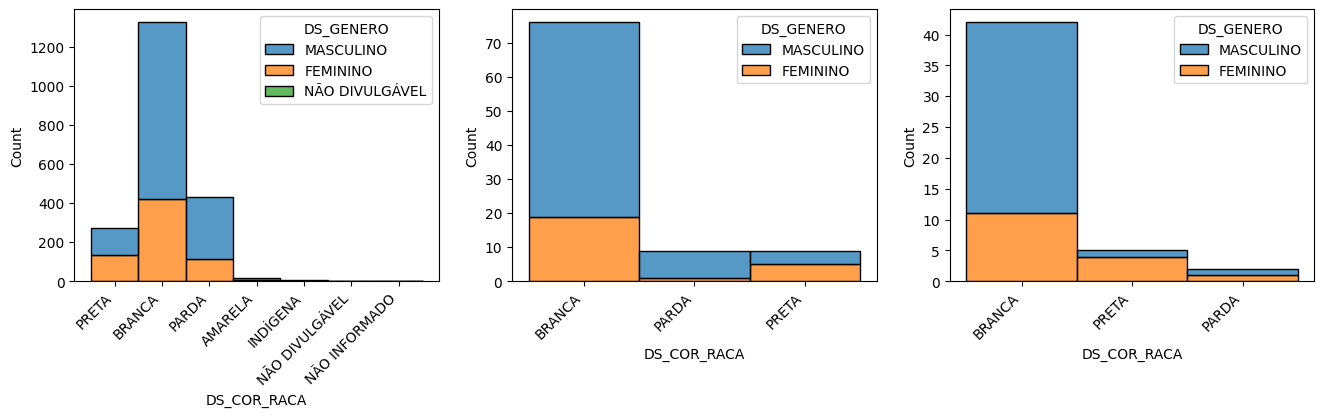

In [30]:
# Visualizando a distribuição de gênero em raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue='DS_GENERO',
    x='DS_COR_RACA',
    multiple='stack',
    ax=ax[0][2],
)

print('Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter')
plt.show()

Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter


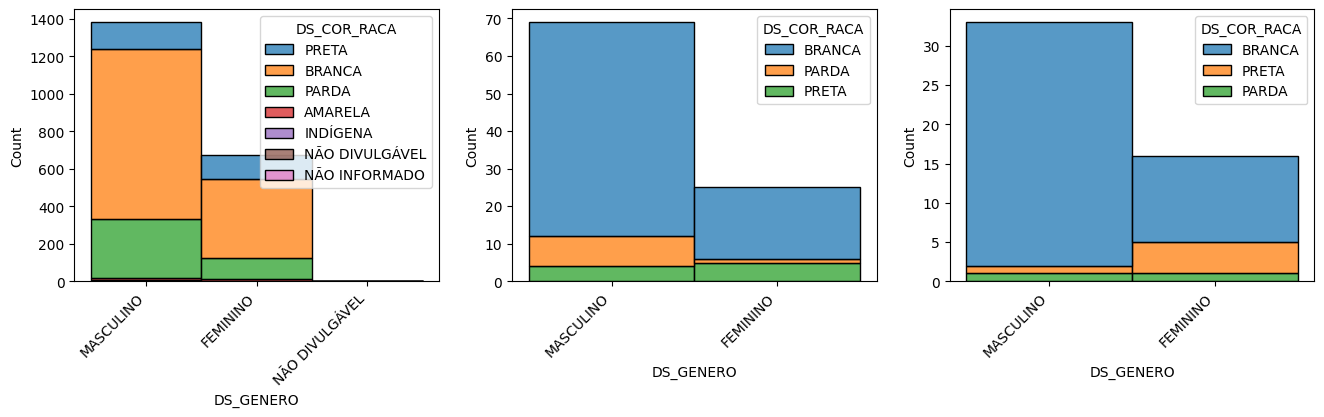

In [31]:
# Visualizando a distribuição de gênero e raça, entre o candidatos, os eleitos e os eleitos com Twitter
fig, ax = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
fig.autofmt_xdate(rotation=45)

sns.histplot(
    data=candidates_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][0],
)

sns.histplot(
    data=elected_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][1],
)

sns.histplot(
    data=twitter_df,
    hue='DS_COR_RACA',
    x='DS_GENERO',
    multiple='stack',
    ax=ax[0][2],
)

print('Candidatos a Deputado Estadual ; Deputados Estaduais Eleitos ; Deputados Estaduais Eleitos com Twitter')
plt.show()

# Extração de dados das contas Twitter

In [32]:
# Vamos listar as contas no twitter dos deputados estaduais eleitos
twitter_df.DS_URL

22                          https://www.twitter/dreltonjr
232              https://twitter.com/EdianeMariaMTST?s=09
276     https://twitter.com/fabibbolsonaro?s=21&t=yq90...
318                      https://twitter.com/delegadoolim
367     https://www.twitter.com/https://twitter.com/le...
391     https://twitter.com/bethsahao?ref_src=twsrc%5E...
427                          https://twitter.com/sppretas
458                    https://www.twitter.com/tomeabduch
459                     https://twitter.com/prcarloscezar
490                        https://twitter.com/majormecca
514                      https://twitter.com/valbolsonaro
560                      https://twitter.com/zimbaldirafa
599                    https://twitter.com/CarlosGiannazi
660              https://twitter.com/tenente_coimbra?s=11
690                   https://twitter.com/rafaelsaraivasp
741                    https://twitter.com/BrunoZambelli3
742                      https://twitter.com/LFTeixeira13
810           

In [33]:
# Como precisamos somente do username, precisamos aplicar uma função
def get_twitter_username(link):
    link = link.rstrip('/')
    username = link.split('/')[-1]
    username = username.split('?')[0]
    return username.lower()

twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)
twitter_df['TW_USER'].describe()

/tmp/ipykernel_27875/2390309642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_USER'] = twitter_df.DS_URL.apply(get_twitter_username)


count            49
unique           49
top       dreltonjr
freq              1
Name: TW_USER, dtype: object

In [34]:
# Vamos raspar os dados numéricos de cada uma das contas do Twitter
usernames = list(twitter_df['TW_USER'])

user_data = {}
for i, username in enumerate(usernames):
    try:
        last_tweet = next(sntwitter.TwitterProfileScraper(username).get_items())
        user_data[username] = {
            'followersCount': last_tweet.user.followersCount,
            'friendsCount': last_tweet.user.friendsCount,
            'statusesCount': last_tweet.user.statusesCount,
            'favouritesCount': last_tweet.user.favouritesCount,
            'listedCount': last_tweet.user.listedCount,
            'mediaCount': last_tweet.user.mediaCount,
        }
        print(f'{i}/{len(usernames)} {username}: {user_data[username]}')
    except Exception as e:
        print(f'{i}/{len(usernames)} {username}: Erro')
        user_data[username] = {
            'followersCount': 0,
            'friendsCount': 0,
            'statusesCount': 0,
            'favouritesCount': 0,
            'listedCount': 0,
            'mediaCount': 0,
        }

0/49 dreltonjr: {'followersCount': 869, 'friendsCount': 461, 'statusesCount': 743, 'favouritesCount': 301, 'listedCount': 1, 'mediaCount': 480}
1/49 edianemariamtst: {'followersCount': 14460, 'friendsCount': 243, 'statusesCount': 3522, 'favouritesCount': 3123, 'listedCount': 41, 'mediaCount': 548}
2/49 fabibbolsonaro: {'followersCount': 15510, 'friendsCount': 7080, 'statusesCount': 92, 'favouritesCount': 499, 'listedCount': 3, 'mediaCount': 36}
3/49 delegadoolim: {'followersCount': 2933, 'friendsCount': 0, 'statusesCount': 1924, 'favouritesCount': 233, 'listedCount': 37, 'mediaCount': 465}
4/49 leosiqueirabr: {'followersCount': 54239, 'friendsCount': 1080, 'statusesCount': 8656, 'favouritesCount': 4835, 'listedCount': 345, 'mediaCount': 918}
5/49 bethsahao: {'followersCount': 2751, 'friendsCount': 1578, 'statusesCount': 9673, 'favouritesCount': 3870, 'listedCount': 70, 'mediaCount': 545}
6/49 sppretas: {'followersCount': 1787, 'friendsCount': 18, 'statusesCount': 283, 'favouritesCount'

In [35]:
# Agora vamos adicionar os dados dos usuários no mesmo dataframe

# Quantidade de seguidores da conta
twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])

# Quantidade de usuarios que a conta segue
twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])

# Quantidade de tweets postados pela conta
twitter_df['TW_statusesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['statusesCount'])

# Quantidade de tweets curtidos pela conta
twitter_df['TW_favouritesCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['favouritesCount'])

twitter_df['TW_listedCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['listedCount'])
twitter_df['TW_mediaCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['mediaCount'])

twitter_df.head()

/tmp/ipykernel_27875/2004623770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_followersCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['followersCount'])
/tmp/ipykernel_27875/2004623770.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_df['TW_friendsCount'] = twitter_df.TW_USER.apply(lambda x: user_data[x]['friendsCount'])
/tmp/ipykernel_27875/2004623770.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,SG_UF,SG_UE,NM_UE,CD_CARGO,DS_CARGO,...,CD_SITUACAO_CANDIDATO_URNA,DS_SITUACAO_CANDIDATO_URNA,ST_CANDIDATO_INSERIDO_URNA,NM_TIPO_DESTINACAO_VOTOS,CD_SITUACAO_CANDIDATO_TOT,DS_SITUACAO_CANDIDATO_TOT,ST_PREST_CONTAS,DS_URL,TW_USER,TW_followersCount,TW_friendsCount,TW_statusesCount,TW_favouritesCount,TW_listedCount,TW_mediaCount
22,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter/dreltonjr,dreltonjr,869,461,743,301,1,480
232,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/EdianeMariaMTST?s=09,edianemariamtst,14460,243,3522,3123,41,548
276,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/fabibbolsonaro?s=21&t=yq90...,fabibbolsonaro,15510,7080,92,499,3,36
318,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://twitter.com/delegadoolim,delegadoolim,2933,0,1924,233,37,465
367,15/02/2023,18:42:41,2022,2,ELEIÇÃO ORDINÁRIA,1,546,Eleições Gerais Estaduais 2022,02/10/2022,ESTADUAL,SP,SP,SÃO PAULO,7,DEPUTADO ESTADUAL,...,2,DEFERIDO,SIM,Válido,2,Deferido,S,https://www.twitter.com/https://twitter.com/le...,leosiqueirabr,54239,1080,8656,4835,345,918


# Exploração dos dados do Twitter

<AxesSubplot: xlabel='TW_followersCount', ylabel='Count'>

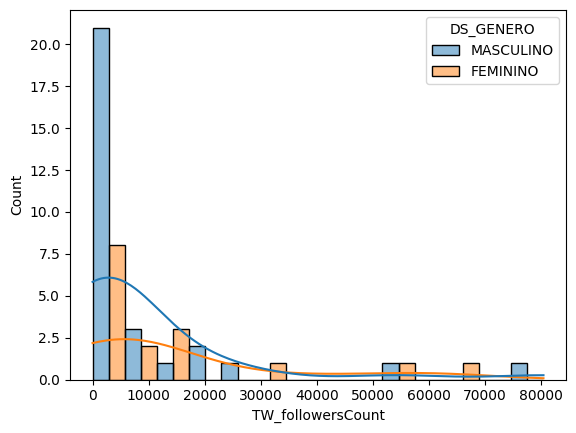

In [28]:
sns.histplot(
    data=twitter_df.loc[twitter_df['TW_followersCount'] < 100000],
    hue='DS_GENERO',
    x='TW_followersCount',
    multiple='dodge',
    kde=True,
)

<AxesSubplot: xlabel='TW_followersCount', ylabel='Count'>

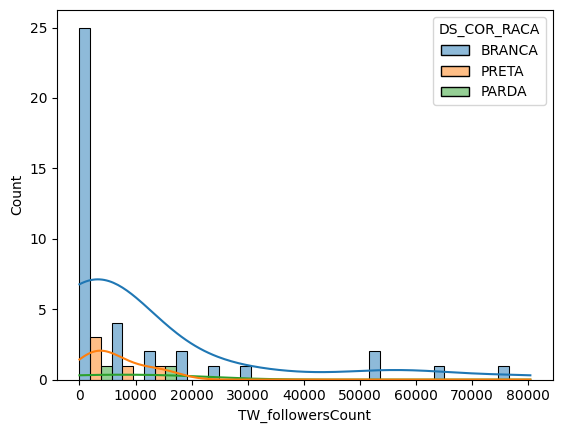

In [29]:
sns.histplot(
    data=twitter_df.loc[twitter_df['TW_followersCount'] < 100000],
    hue='DS_COR_RACA',
    x='TW_followersCount',
    multiple='dodge',
    kde=True,   
)

# Exportação de dados

In [30]:
# Exportando dados scrapeados

output_path = 'datasets/scrapped/'
output_file = f'deputados-estaduais-sp-{datetime.now().isoformat()}.csv'

# Para salvar os dados, descomente as linhas abaixo
# twitter_df.to_csv(f"{output_path}{output_file}", sep=';', encoding='utf-8', index=False)